In [49]:
path="fashion_data/"

import gzip
import numpy as np
import torch
import gzip
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

label_file=gzip.open(path + 'train-labels-idx1-ubyte.gz')
y_train= np.frombuffer(label_file.read(), dtype=np.uint8, offset=8)

image_file=gzip.open(path + 'train-images-idx3-ubyte.gz', 'rb')
x_train= np.frombuffer(image_file.read(), dtype=np.uint8, offset=16).reshape(len(y_train), 784)

valid_label_file=gzip.open(path + 't10k-labels-idx1-ubyte.gz')
y_valid= np.frombuffer(valid_label_file.read(), dtype=np.uint8, offset=8)

valid_image_file=gzip.open(path + 't10k-images-idx3-ubyte.gz', 'rb')
x_valid= np.frombuffer(valid_image_file.read(), dtype=np.uint8, offset=16).reshape(len(y_valid), 784)

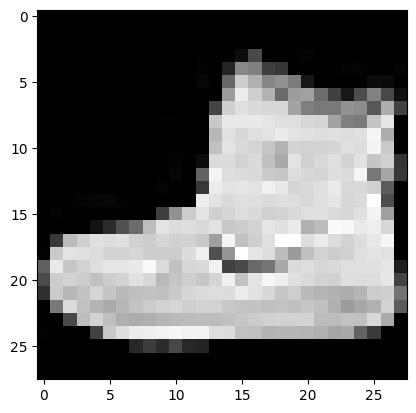

In [50]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

In [51]:
y_train[0]

9

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

Überlegungen:
28*28 -> 784 Neuronen
128 Neuronen im Hidden Layer
128 Neuronen im Hidden Layer 2
10 Neuronen im Output Layer

In [52]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).long()

In [53]:
def show_images(x, y, index, num):
    fig, axes = plt.subplots(1, num, figsize=(1.5*num, 2))
    for i in range(num):
        axes[i].imshow(x[index+i].reshape(28, 28), cmap='gray')
        axes[i].set_title('label: ' + str(y[index+i]))
    plt.show()

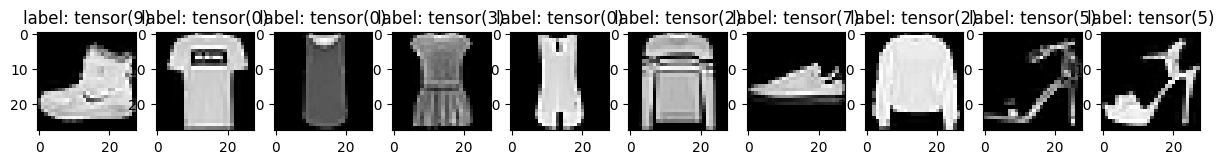

In [54]:
show_images(x_train, y_train, 0, 10)

# Building the model

In [55]:
class fully_connected(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(fully_connected, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)

        self.bn1 = nn.BatchNorm1d(hidden_size[0])
        self.bn2 = nn.BatchNorm1d(hidden_size[1])

    def forward(self, xb):
        #print('xb',xb.shape, xb.dtype)
        z2 = self.fc1(xb) # z2 = w1*x + b1
        #print('z2',z2.shape, z2.dtype)
        a2 = torch.relu(z2) # negative values are set to zero
        #print('a2',a2.shape, a2.dtype)
        a2_bn = self.bn1(a2) # batch normalization

        z3 = self.fc2(a2_bn) # z3 = w2*a2 + b2
        #print('z3',z3.shape)
        a3 = torch.relu(z3) 
        #print('a3',a3.shape)
        a3_bn = self.bn2(a3) 

        #print('a2_bn',a2_bn.shape)
        y_hat = torch.relu(self.fc3(a3_bn)) # y_hat = w2*a2 + b2
        #print('y_hat',y_hat.shape)
        return y_hat
    
def get_batch(x, y, batch_size):
    for i in range(0, x.shape[0], batch_size):
        yield x[i:i+batch_size], y[i:i+batch_size]

100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


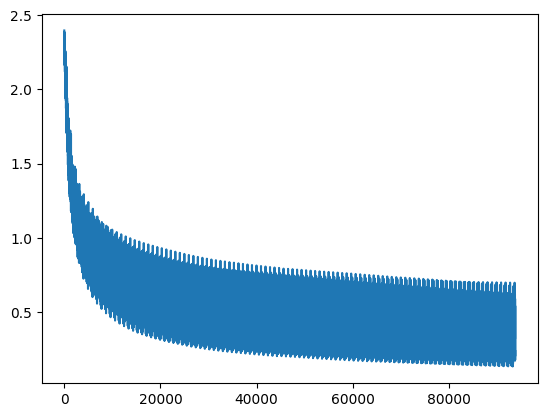

In [56]:
model = fully_connected(input_size=784, hidden_size=(128, 128), output_size=10)
loss = nn.CrossEntropyLoss()
lr = 0.0001
batch_size = 64

def train(xb, yb):
    y_hat = model(xb)
    loss_value = loss(y_hat, yb)
    loss_value.backward()
    with torch.no_grad():
        for p in model.parameters():
            p -= p.grad * lr
        model.zero_grad()
    return loss_value.item()

losses = []
from tqdm import tqdm
for epoch in tqdm(range(100)):
    for xb, yb in get_batch(x_train, y_train, batch_size):
        loss_value = train(xb, yb)
        losses.append(loss_value)

plt.plot(losses)